In [ ]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from cvxopt import matrix, solvers

### 0. Sample data

In [2]:
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # class 1
X1 = np.random.multivariate_normal(means[1], cov, N) # class -1 
X = np.concatenate((X0.T, X1.T), axis = 1) # all data 
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1) # labels 

In [3]:
y

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.]])

In [4]:
X

array([[2.37319011, 1.51261889, 2.4696794 , 1.78736889, 1.81231157,
        2.03717355, 1.53790057, 2.29312867, 1.38805594, 1.57279694,
        1.42746579, 2.24760864, 1.33595491, 1.69420104, 2.53897645,
        1.3071994 , 2.13924705, 2.47383468, 2.00512009, 2.28205624,
        3.84539996, 4.08296992, 4.39101392, 4.87226421, 4.67924793,
        3.5072737 , 4.2420991 , 3.81422204, 4.36215577, 4.67585469,
        4.26900691, 3.96389821, 4.99838625, 4.04777396, 3.60992639,
        3.61724181, 4.74874995, 3.60912757, 3.45689723, 4.71163383],
       [1.71875981, 1.40558943, 2.02144973, 1.29380961, 1.56119497,
        1.93397133, 1.87434722, 2.76537389, 1.86419379, 0.90707347,
        0.71254431, 2.39846497, 1.61731637, 1.94273986, 2.54957308,
        0.19362396, 2.09561534, 2.41269466, 1.89290099, 1.79675607,
        1.55967159, 3.02486694, 2.17637385, 3.05096564, 2.36893594,
        1.74738715, 2.49062268, 1.75348866, 2.57895032, 2.85696676,
        1.71816697, 3.08918682, 3.04064226, 2.2

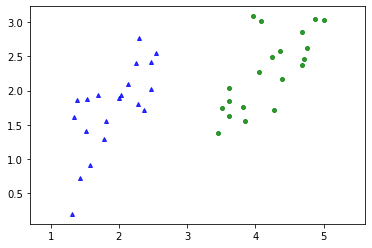

In [5]:
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
plt.axis('equal')
plt.plot()
plt.show()

### 1. Solve SVM using optimization of dual function

In [6]:
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V)) # see definition of V, K near eq (8)

p = matrix(-np.ones((2*N, 1))) # all-one vector 
# build A, b, G, h 
G = matrix(-np.eye(2*N)) # for all lambda_n >= 0
h = matrix(np.zeros((2*N, 1)))
A = matrix(y) # the equality constrain is actually y^T lambda = 0
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = ')
print(l.T)

lambda = 
[[1.31788685e-07 2.77147190e-09 1.73654462e+00 4.78549254e-09
  4.08907371e-09 4.99588183e-09 2.39580510e-09 4.33202944e-09
  2.11008024e-09 4.01881506e-09 3.47769913e-09 5.37184704e-09
  2.15964931e-09 2.75859342e-09 5.53767869e-09 3.87921914e-09
  5.54964568e-09 7.69572856e-09 4.79586762e-09 1.83380182e-08
  4.86018185e-09 1.52985375e-08 2.81560637e-09 2.30161436e-09
  2.24733870e-09 1.73654459e+00 4.26844717e-09 6.51055590e-09
  3.59022712e-09 2.63726980e-09 2.70889306e-09 6.29348418e-08
  2.06278123e-09 5.70265249e-09 9.08462824e-08 1.12316521e-08
  2.27373725e-09 2.45670401e-08 3.57350133e-09 2.24603506e-09]]


In [7]:
epsilon = 1e-6 # just a small number, greater than 1e-9
S = np.where(l > epsilon)[0]

VS = V[:, S]
XS = X[:, S]
yS = y[:, S]
lS = l[S]
# calculate w and b
w = VS.dot(lS)
b = np.mean(yS.T - w.T.dot(XS))

print('w = ', w.T)
print('b = ', b)

w =  [[-1.80182869  0.47592196]]
b =  4.487886673710467


In [8]:
# w1*x1 + w2*x2 + b = 0
sepX1 = np.linspace(2.3, 3.3, 100)
sepX2 = -b/w[1] - w[0]*sepX1/w[1]

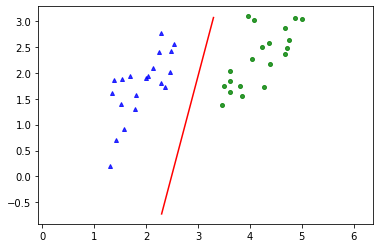

In [9]:
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
plt.plot(sepX1, sepX2, '-r', label="%f*x1 + %f*x2 + %f = 0"%(w[0], w[1], b))
plt.axis('equal')
plt.plot()
plt.show()

### 2. Solve SVM using sklearn-svm, cvxopt and gradient descent for SVM soft margin

#### Prepare data

In [10]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) 
X1 = np.random.multivariate_normal(means[1], cov, N)

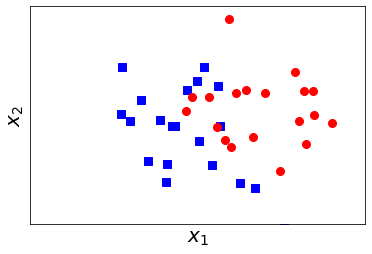

In [11]:
#with PdfPages('data.pdf') as pdf:
plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

# hide tikcs 
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
    #pdf.savefig()
    # plt.savefig('logistic_2d.png', bbox_inches='tight', dpi = 300)
plt.show()

In [12]:
X = np.vstack((X0, X1))
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))

#### Using sklearn

In [13]:
from sklearn.svm import SVC

In [14]:
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

In [15]:
print(w_sklearn.T, b_sklearn)

[[-1.87461946 -1.80697358]] 8.496911901960104


#### Using duality problem

In [16]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.11381472e-06 9.99999967e+01 1.10533113e-06 6.70163542e-06
  3.40838760e+01 4.73972851e-06 9.99999978e+01 3.13320448e-06
  9.99999985e+01 5.06729333e+01 9.99999929e+01 3.23564235e-06
  9.99999984e+01 9.99999948e+01 1.37977626e-06 9.99997155e+01
  3.45005661e-06 1.46190315e-06 5.50601998e-06 1.45062544e-06
  1.85373848e-06 1.14181647e-06 8.47565685e+01 9.99999966e+01
  9.99999971e+01 8.00764710e-07 2.65537194e-06 1.45230729e-06
  4.15737086e-06 9.99999887e+01 9.99999761e+01 8.98414772e-07
  9.99999979e+01 1.75651608e-06 8.27947898e-07 1.04289117e-06
  9.99999969e+01 9.07920761e-07 8.83138298e-07 9.99999971e+01]]


In [ ]:
l.T

In [17]:
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .99*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

In [18]:
XT = X.T # we need each col is one data point in this alg
VS = V[:, S]
# XS = XT[:, S]
# yS = y[ S]
lS = l[S]
# lM = l[M]
yM = y[M]
XM = XT[:, M]
w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))

In [19]:
print(w_dual.T, b_dual) 

[[-1.87457279 -1.80695039]] 8.496721098145045


#### Using gradient descent

In [20]:
def cost(w, lam):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]

def grad(w, lam):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp, lam) - cost(wm, lam))/(2*eps)
    return g 

In [21]:
def grad_descent(w0, eta, lam):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w, lam)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w, lam))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 

In [22]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

In [23]:
w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0, lam)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient difference: %f' %diff)

Gradient difference: 0.000000


In [24]:
w0 = np.random.randn(X0_bar.shape[0], 1) 
w = grad_descent(w0, 0.001, lam)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 62.790027
iter 10001 cost: 15.755286
iter 20001 cost: 15.744316
iter 30001 cost: 15.724746
iter 40001 cost: 15.710856
iter 50001 cost: 15.694064
iter 60001 cost: 15.681147
iter 70001 cost: 15.673648
iter 80001 cost: 15.664280
iter 90001 cost: 15.664696
[[-1.86263592 -1.79456742]] [8.44935171]


In [25]:
def plotResult(X0, X1, w, b, title):
    fig, ax = plt.subplots()

    w0 = w[0]
    w1 = w[1]
    x1 = np.arange(-10, 10, 0.1)
    y1 = -w0/w1*x1 - b/w1
    y2 = -w0/w1*x1 - (b-1)/w1
    y3 = -w0/w1*x1 - (b+1)/w1
    plt.plot(x1, y1, 'k', linewidth = 3)
    plt.plot(x1, y2, 'k')
    plt.plot(x1, y3, 'k')

    # equal axis and lim
    plt.axis('equal')
    plt.ylim(0, 3)
    plt.xlim(2, 4)

    # hide tikcs 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    # fill two regions
    y4 = 10*x1
    plt.plot(x1, y1, 'k')
    plt.fill_between(x1, y1, color='blue', alpha='0.1')
    plt.fill_between(x1, y1, y4, color = 'red', alpha = '.1')

    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.title('Solution found by ' + title, fontsize=12)

    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
    plt.show()

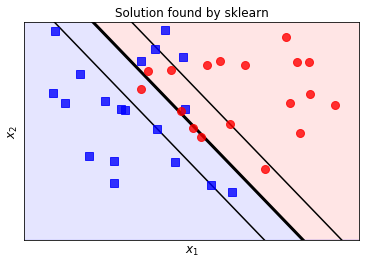

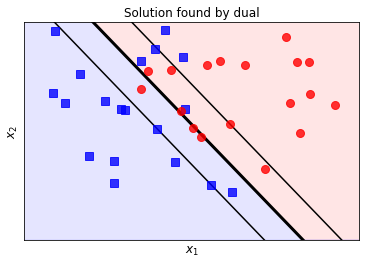

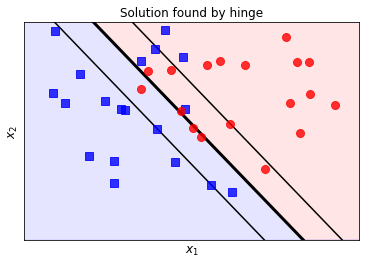

In [26]:
plotResult(X0, X1, w_sklearn, b_sklearn, 'sklearn')
plotResult(X0, X1, w_dual, b_dual, 'dual')
plotResult(X0, X1, w_hinge, b_hinge, 'hinge')

In [27]:
# Change C
lsC = [1e-2, 1, 10, 1000]

iter 1 cost: 63.152086
[[-0.26597685 -0.10252722]] [0.51384458]


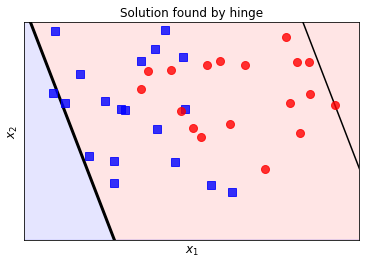

iter 1 cost: 41.500885
iter 10001 cost: 17.247928
iter 20001 cost: 17.246850
iter 30001 cost: 17.257192
iter 40001 cost: 17.246764
iter 50001 cost: 17.246005
iter 60001 cost: 17.249043
iter 70001 cost: 17.248268
iter 80001 cost: 17.247521
iter 90001 cost: 17.246766
[[-1.07999181 -1.08172316]] [5.32459356]


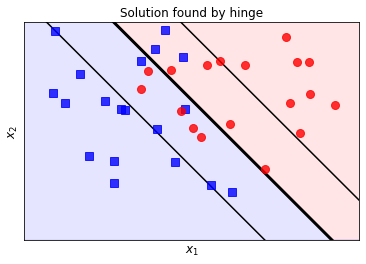

iter 1 cost: 80.946891
iter 10001 cost: 15.914234
iter 20001 cost: 15.926898
iter 30001 cost: 15.905940
iter 40001 cost: 15.914622
iter 50001 cost: 15.914128
iter 60001 cost: 15.926790
iter 70001 cost: 15.906097
iter 80001 cost: 15.914515
iter 90001 cost: 15.914017
[[-1.31194901 -1.25959209]] [6.23154089]


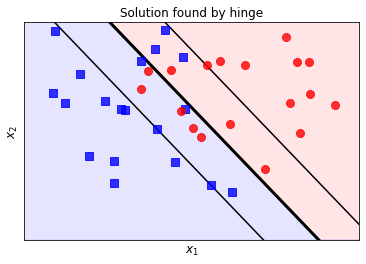

iter 1 cost: 65.750434
iter 10001 cost: 15.739214
iter 20001 cost: 15.711834
iter 30001 cost: 15.700432
iter 40001 cost: 15.675531
iter 50001 cost: 15.649431
iter 60001 cost: 15.633358
iter 70001 cost: 15.642590
iter 80001 cost: 15.644661
iter 90001 cost: 15.642853
[[-1.86607149 -1.79595957]] [8.44999285]


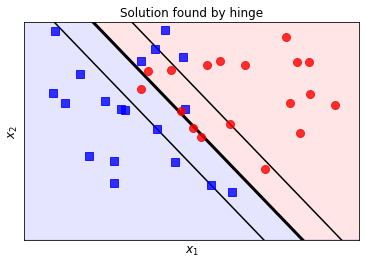

In [28]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
for C in lsC:
    lam = 1./C
    w0 = np.random.randn(X0_bar.shape[0], 1) 
    w = grad_descent(w0, 0.001, lam)
    w_hinge = w[:-1].reshape(-1, 1)
    b_hinge = w[-1]
    print(w_hinge.T, b_hinge)
    plotResult(X0, X1, w_hinge, b_hinge, 'hinge')

### 3. Kernel function demo

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# XOR dataset and targets
X = np.c_[(0, 0),
          (1, 1),
          #---
          (1, 0),
          (0, 1)].T
Y = [0] * 2 + [1] * 2

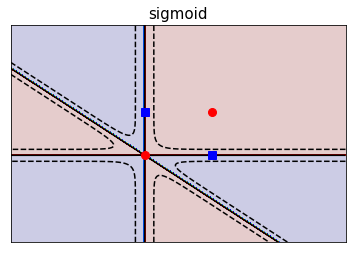

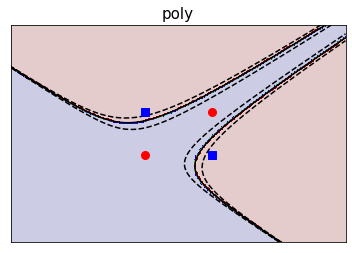

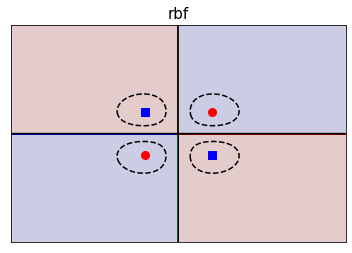

In [30]:
# figure number
fignum = 1

# fit the model
for kernel in ('sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=4, coef0 = 0)
    clf.fit(X, Y)
    # plot the line, the points, and the nearest vectors to the plane
    fig, ax = plt.subplots()
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='None')
    plt.plot(X[:2, 0], X[:2, 1], 'ro', markersize = 8)
    plt.plot(X[2:, 0], X[2:, 1], 'bs', markersize = 8)

    plt.axis('tight')
    x_min, x_max = -2, 3
    y_min, y_max = -2, 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])
    plt.title(kernel, fontsize = 15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

### 4. SVM applications

In [31]:
import pandas as pd

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix 
from sklearn import datasets

In [33]:
## Iris flowers classification using svm
filename = "IRIS.csv"
pdfData = pd.read_csv(filename)
pdfData.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [34]:
pdfData.shape

(150, 5)

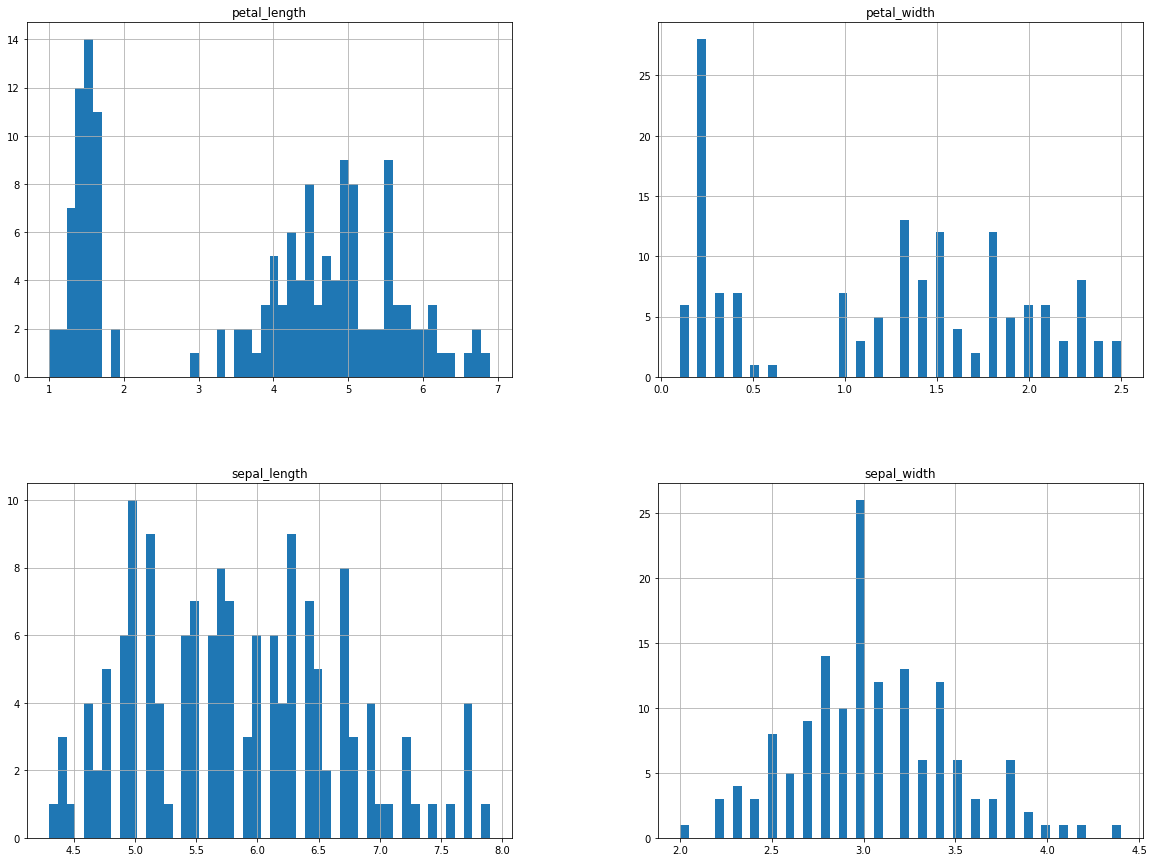

In [35]:
pdfData.hist(bins=50, figsize=(20,15))
plt.show()

In [36]:
trainSet, testSet = train_test_split(pdfData, test_size=0.2, random_state=42)

In [37]:
lsLabel = set(pdfData["species"])
print(lsLabel)

{'Iris-setosa', 'Iris-virginica', 'Iris-versicolor'}


In [38]:
pdfData.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [39]:
for l in lsLabel:
    pdfData["label_%s"%l[5:]] = (pdfData["species"] == l)

In [40]:
pdfData.head()

,sepal_length,sepal_width,petal_length,petal_width,species,label_setosa,label_virginica,label_versicolor
0,5.1,3.5,1.4,0.2,Iris-setosa,True,False,False
1,4.9,3.0,1.4,0.2,Iris-setosa,True,False,False
2,4.7,3.2,1.3,0.2,Iris-setosa,True,False,False
3,4.6,3.1,1.5,0.2,Iris-setosa,True,False,False
4,5.0,3.6,1.4,0.2,Iris-setosa,True,False,False


In [41]:
# Look for correlation
corrMatrix = pdfData.corr()

In [42]:
corrMatrix

,sepal_length,sepal_width,petal_length,petal_width,label_setosa,label_virginica,label_versicolor
sepal_length,1.000000,-0.109369,0.871754,0.817954,-0.717416,0.638020,0.079396
sepal_width,-0.109369,1.000000,-0.420516,-0.356544,0.595601,-0.130901,-0.464700
petal_length,0.871754,-0.420516,1.000000,0.962757,-0.922688,0.721102,0.201587
petal_width,0.817954,-0.356544,0.962757,1.000000,-0.887510,0.769134,0.118376
label_setosa,-0.717416,0.595601,-0.922688,-0.887510,1.000000,-0.500000,-0.500000
label_virginica,0.638020,-0.130901,0.721102,0.769134,-0.500000,1.000000,-0.500000
label_versicolor,0.079396,-0.464700,0.201587,0.118376,-0.500000,-0.500000,1.000000


In [43]:
for l in lsLabel:
    print(corrMatrix["label_%s"%l[5:]].sort_values(ascending=False))
    print("-"*30)

label_setosa        1.000000
sepal_width         0.595601
label_versicolor   -0.500000
label_virginica    -0.500000
sepal_length       -0.717416
petal_width        -0.887510
petal_length       -0.922688
Name: label_setosa, dtype: float64
------------------------------
label_virginica     1.000000
petal_width         0.769134
petal_length        0.721102
sepal_length        0.638020
sepal_width        -0.130901
label_versicolor   -0.500000
label_setosa       -0.500000
Name: label_virginica, dtype: float64
------------------------------
label_versicolor    1.000000
petal_length        0.201587
petal_width         0.118376
sepal_length        0.079396
sepal_width        -0.464700
label_setosa       -0.500000
label_virginica    -0.500000
Name: label_versicolor, dtype: float64
------------------------------


In [44]:
lsFt = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
training = trainSet[lsFt].dropna().values
trainingLabel = trainSet["species"].copy()

In [45]:
test = testSet[lsFt].dropna().values
testLabel = testSet["species"].copy()

In [46]:
clf = {}
predictions = {}
lsKernel = ('linear', 'poly', 'rbf')
for kernel in lsKernel:
    clf[kernel] = svm.SVC(kernel=kernel, gamma=4, coef0 = 0)

In [47]:
lsLabel

{'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'}

In [ ]:
import seaborn as sns

In [ ]:
for kernel in lsKernel:
    print(kernel)
    labels = list(lsLabel)
    clf[kernel].fit(training, trainingLabel)
    
    predictions[kernel] = clf[kernel].predict(test) 

    # model accuracy for X_test   
    accuracy = clf[kernel].score(test, testLabel) 
    print(accuracy)

    # creating a confusion matrix 
    cm = confusion_matrix(testLabel, predictions[kernel], labels) 
    print(cm)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(cm, annot=True, ax = ax)
    # cax = ax.matshow(cm, cmaps="jet")
    # plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("-"*30)
